# Neuroevolution

Today we are going to experiment with neuroevolution and see how to implement simple neuroevolutionary algorithms. We will start by implementing a simple weight evolution, then we will also try NEAT.

The evolution of only weights is very simple, we just need to implement a simple neural network with a method to set the weigths from a vector. Then we evolve an individual that contains only this vector. During the evaluation, we set the network weigths according to the individual and evaluate it. In this way, we try to implement classification on the well-known iris problem.

In [2]:
from sklearn import datasets, model_selection
import numpy as np

# read the data and divide them into training and testing sets
iris = datasets.load_iris()
train_x, test_x, train_y, test_y = model_selection.train_test_split(iris.data, iris.target)

import collections

# prepare a simple implementation of a neural network
class NeuralNetwork:

    def __init__(self, layer_sizes, activations):
        self.layer_sizes = layer_sizes
        self.layers = None

        if isinstance(activations, list):
            if len(list(activations)) != len(layer_sizes) - 1:
                raise AttributeError("Number of activations does not match number of layers")
            self.activations = list(activations)
        else:
            self.activations = [activations] * (len(layer_sizes) - 1)

        self.vectorized_net = None

    # number of network parameters
    def vectorized_size(self):
        return sum(map(lambda x: (x[0] + 1) * x[1], zip(self.layer_sizes, self.layer_sizes[1:])))

    # set the parameters based on a vector
    def set_weights(self, vectorized_net):

        if len(vectorized_net) != self.vectorized_size():
            raise AttributeError(
                f"Length of vector does not match vectorized_size: {len(vectorized_net)} != {self.vectorized_size()}")

        self.vectorized_net = vectorized_net

        self.layers = []

        sum_sizes = 0
        for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
            layer = vectorized_net[sum_sizes: sum_sizes + (p + 1) * n]
            self.layers.append(np.reshape(layer, newshape=(p + 1, n)))
            sum_sizes += (p + 1) * n

    def eval_network(self, inputs):

        activations = inputs
        try:
            for act_func, layer in zip(self.activations, self.layers):
                activations_1 = np.append(np.array([1.0]), activations)  # add constant 1.0 for the bias term
                activations = act_func(np.dot(activations_1, layer))
        except Exception as e:
            print("Activations:", activations)
            raise e

        return activations

We use the CMA-ES algorithm for setting the weights of the neural network. CMA-ES is an evolutionary strategy that adapts the entire covariance matrix of a multinomial normal distribution. It is implemented in the deap library we have already seen and it is easy to use.

In [2]:
def relu(x):
    return np.maximum(0,x)

def linear(x):
    return x

net = NeuralNetwork([4, 5, 3], [relu, linear])
ind_size = net.vectorized_size()

def fitness(ind, X, y):
    net.set_weights(ind)
    
    acc = 0
    for xi, yi in zip(X, y):
        if np.argmax(net.eval_network(xi)) == yi:
            acc += 1
    
    return acc/len(y),
        
from deap import algorithms, creator, base, benchmarks, cma, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("evaluate", fitness, X=train_x, y=train_y)

strategy = cma.Strategy(centroid=[0.0]*ind_size, sigma=0.1, lambda_=5*ind_size)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

_ = algorithms.eaGenerateUpdate(toolbox, ngen=75, stats=stats, halloffame=hof)

gen	nevals	avg     	std      	min	max     
0  	215   	0.329527	0.0694924	0  	0.678571
1  	215   	0.346512	0.0996277	0  	0.678571
2  	215   	0.337334	0.0877837	0  	0.678571
3  	215   	0.343148	0.106436 	0  	0.678571
4  	215   	0.355772	0.104021 	0  	0.678571
5  	215   	0.364161	0.130523 	0  	0.678571
6  	215   	0.367733	0.100276 	0.0446429	0.678571
7  	215   	0.392483	0.131065 	0        	0.8125  
8  	215   	0.409344	0.133381 	0.0803571	0.732143
9  	215   	0.40162 	0.131587 	0.0178571	0.6875  
10 	215   	0.448131	0.15204  	0.107143 	0.714286
11 	215   	0.45    	0.170679 	0        	0.928571
12 	215   	0.431769	0.15001  	0.0178571	0.767857
13 	215   	0.457641	0.161945 	0.0357143	0.919643
14 	215   	0.453032	0.161128 	0        	0.9375  
15 	215   	0.445141	0.155823 	0.0267857	0.803571
16 	215   	0.475042	0.163859 	0.0892857	0.910714
17 	215   	0.473671	0.164554 	0.00892857	0.901786
18 	215   	0.482932	0.166488 	0         	0.830357
19 	215   	0.52255 	0.165181 	0.214286  	0.946429
20 	215   

We will evaluate the accuracy on the testing data.

In [3]:
fitness(hof[0], test_x, test_y)

(0.9736842105263158,)

# NEAT

The NEAT algorithms is implemented in the `neat-python` library. The library has a slightly different interface than what we are used to, but it is not difficult to learn how to use it. The algorithm settings are loaded from a file, and then we just run the algorithm. Below we show an example from the `neat-python` documentation modified for iris classification.

For the visualization of the network, you will need to install the `python-graphviz` package.


 ****** Running generation 0 ****** 

Population's average fitness: 36.40667 stdev: 13.49128
Best fitness: 76.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.479
Mean genetic distance 1.210, standard deviation 0.269
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150     76.0    0.479     0
Total extinctions: 0
Generation time: 0.230 sec

 ****** Running generation 1 ****** 

Population's average fitness: 40.66000 stdev: 15.52281
Best fitness: 76.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.535
Mean genetic distance 1.170, standard deviation 0.277
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150     76.0    0.535     1
Total extinctions: 0
Generation time: 0.235 sec (0.232 average)

 ****** Running generation 2 ****** 

Population's average fitness: 48.41333 st

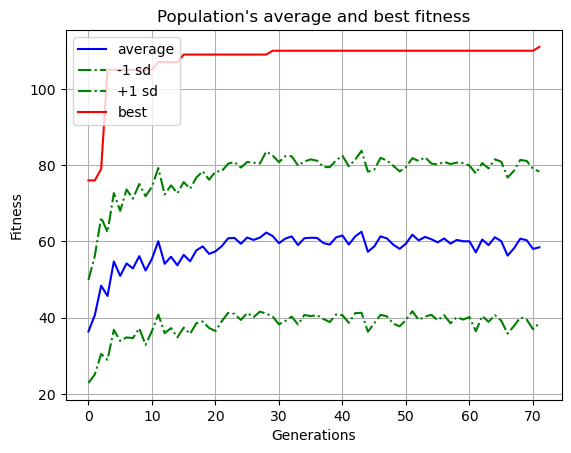

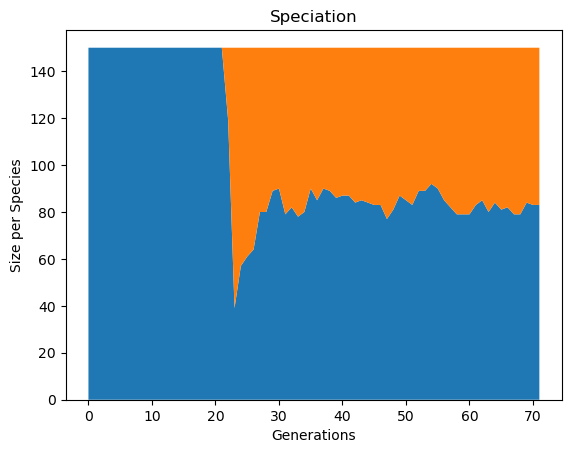

Mean genetic distance 1.508, standard deviation 0.387
Mean genetic distance 1.567, standard deviation 0.368
Mean genetic distance 1.626, standard deviation 0.333
Mean genetic distance 1.606, standard deviation 0.324
Mean genetic distance 1.677, standard deviation 0.327
Mean genetic distance 1.825, standard deviation 0.342
Mean genetic distance 1.838, standard deviation 0.349
Mean genetic distance 1.962, standard deviation 0.305
Mean genetic distance 1.932, standard deviation 0.316
Mean genetic distance 1.846, standard deviation 0.279


In [3]:
import os
import neat
import visualize

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(train_x, train_y):
            output = net.activate(xi)
            genome.fitness += 1 if np.argmax(output) == xo else 0


def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 300)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(train_x, train_y):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    node_names = {-1:'x1', -2: 'x2', -3: 'x3', -4: 'x4', 0:'setosa', 1:'virginica', 2:'versicolor'}
    visualize.draw_net(config, winner, True, node_names=node_names)
    visualize.plot_stats(stats, ylog=False, view=True)
    visualize.plot_species(stats, view=True)

    p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    p.run(eval_genomes, 10)


if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    config_path = os.path.join('.', 'config-feedforward')
    run(config_path)